In [16]:
!pip install iminuit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 382.1/382.1 kB 5.4 MB/s eta 0:00:00a 0:00:01


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import iminuit
from iminuit import Minuit, cost
from numba_stats import norm, truncexpon, crystalball, expon
from scipy.optimize import curve_fit

#read the data from the csv file
data = np.genfromtxt('/home/aavash/Downloads/data_from_lab/filtered_by_type/inv_mass_filtered_all_Bminus.csv', delimiter=',')
data_plus = np.genfromtxt('/home/aavash/Downloads/data_from_lab/filtered_by_type/inv_mass_filtered_all_Bplus.csv', delimiter=',')

In [3]:
def fit_crystal(x, beta, m , loc, scale, c_norm, 
                comb_mu, comb_sigma, comb_n,
                tau, xoffset, exp_norm, total_norm
                ):
    crystal_val = crystalball.pdf(x, beta, m, loc, scale) * c_norm
    comb_val = norm.pdf(x, comb_mu, comb_sigma) * comb_n
    exp_val = expon.pdf(x, tau, xoffset) * exp_norm
    return (crystal_val + comb_val + exp_val) * total_norm
def fit_curve_post_minut(data, p0_vals):
    #fit the data with a gaussian
    hist_raw = plt.hist(data, bins=100, histtype='step', label='raw data');
    bin_centers = 0.5 * (hist_raw[1][1:] + hist_raw[1][:-1])
    bin_heihgts = hist_raw[0]
    popt, pcov = curve_fit(fit_crystal, bin_centers, bin_heihgts, p0=p0_vals)

    return popt, pcov


In [3]:
def multiplier_one(x, x_bar, sigma, n):
    multiplier_one = np.exp(-0.5 * (x - x_bar) ** 2 / sigma ** 2)
    return multiplier_one

def multiplier_two(x, A, B, x_bar, sigma, n):
    multiplier_two = A * (np.abs(B - (x - x_bar) / sigma)) ** (-n)
    return multiplier_two

In [4]:
from scipy.special import erf
def crystal_ball_function(x, alpha, n, x_bar, sigma, normalisation):

    n = np.abs(n)
    #clip the alpha value to avoid underflow
    alpha = np.clip(alpha, 1e-5, 1e10)
    A = ((n / np.abs(alpha))) ** n * (np.exp(-0.5 * alpha ** 2))
    A = np.abs(A)
    B = (n / np.abs(alpha)) - np.abs(alpha)
    C = (n / np.abs(alpha)) * (1 / (n - 1)) * np.exp(-0.5 * alpha ** 2)
    D = np.sqrt(np.pi / 2) * (1 + erf(alpha / np.sqrt(2)))
    
    N = normalisation / (sigma * (C + D))
    if D < 0:
        print('N is negative')
    
    #np.where(((x) / sigma > -alpha), print(x), print('x is negative'))
    alpha = max(alpha, 1e-10)


    # multiplier_one = np.exp(- 0.5 * ((x - x_bar) / sigma) ** 2)
    # multiplier_two = A * (B - ((x - x_bar) / sigma)) ** (-n)

    return N * np.where((( x - x_bar) / sigma > -alpha),
                        multiplier_one(x, x_bar, sigma, n),
                        multiplier_two(x, A, B, x_bar, sigma, n))

#fit a gaussian to the dataset 
def gaussian(x, mean, sigma, norm):
    return np.array( (1 / sigma) * norm * np.exp( -0.5 * ( (x-mean)/sigma )**2 ) )

def exponential(x, decay, xoffset, norm):
# this is a technical parameter, which can be used to move the position at which the function evaluates to "norm"
    return np.array(decay  * norm * np.exp(-(x-xoffset)*decay) )

def half_gaussian(x, mean, sigma, norm):
    return np.array( (1 / sigma) * norm * np.exp( -0.5 * ( (x-mean)/sigma )**2 ) * (x > mean) )

# implement the Crystal Ball function



def only_gaussian(x, half_gaussian_xbar, half_gaussian_sigma, half_gaussian_normalisation,
                  gaussian_x_bar, gaussian_sigma, gaussian_normalisation,
                  exponential_decay, exponential_offset, exponential_normalisation,
                  total_normalisation):
    
    half_gaussian_result = half_gaussian(x, half_gaussian_xbar, half_gaussian_sigma, half_gaussian_normalisation)
    gaussian_result = gaussian(x, gaussian_x_bar, gaussian_sigma, gaussian_normalisation)
    exponential_result = exponential(x, exponential_decay,  exponential_offset, exponential_normalisation)
    total_result = total_normalisation * (half_gaussian_result + gaussian_result + exponential_result)
    return total_result


def total_func(x,
                crystal_alpha, crystal_n, crystal_x_bar, crystal_sigma, crystal_normalisation,
                half_gaussian_x_bar, half_gaussian_sigma, half_gaussian_normalisation,
                exponential_decay, exponential_offset, exponential_normalisation,
                total_normalisation):
    
    crystal_ball_result = crystal_ball_function(x, crystal_alpha, crystal_n, crystal_x_bar, crystal_sigma, crystal_normalisation)
    half_gaussian_result = half_gaussian(x, half_gaussian_x_bar, half_gaussian_sigma, half_gaussian_normalisation)
    exponential_result = exponential(x, exponential_decay,  exponential_offset, exponential_normalisation)
    total_result = total_normalisation * (crystal_ball_result + half_gaussian_result + exponential_result)
    return total_result



In [5]:
bounds_dict = {'crystal_alpha': (-10, 10),
                'crystal_n': (0, 10),
                'crystal_x_bar': (5200, 5800),
                'crystal_sigma': (0, 1000),
                'crystal_normalisation': (0, 1e10),
                'half_gaussian_x_bar': (5000, 5200),
                'half_gaussian_sigma': (0, 1000),
                'half_gaussian_normalisation': (0, 1e10),
                'exponential_x_bar': (5200, 5800),
                'exponential_tau': (0, 1000),
                'exponential_normalisation': (0, 1000),
                'total_normalisation': (0, 1000)
                }
            
initial_guess = {
                'crystal_alpha': 1,
                'crystal_n': 10,
                'crystal_x_bar': 5300,
                'crystal_sigma': 100,
                'crystal_normalisation': 1e8,
                'half_gaussian_x_bar': 5100,
                'half_gaussian_sigma': 100,
                'half_gaussian_normalisation': 1e7,
                'exponential_x_bar': 5500,
                'exponential_tau': 100,
                'exponential_normalisation': 100,
                'total_normalisation': 100
            }

#prase the bounds and put the lower and upper bounds in two different lists
upper_bound = []
lower_bound = []
for key, value in bounds_dict.items():
    upper_bound.append(value[1])
    lower_bound.append(value[0])

initial_guess_mixture = []
for key, value in initial_guess.items():
    initial_guess_mixture.append(value)

assert(len(initial_guess_mixture) == len(upper_bound) == len(lower_bound))
#place the two bounds lists into a tuple
bounds_mixture = (lower_bound, upper_bound)

Iminuit stuff!



In [6]:
initial_guess = {
                'crystal_alpha': 1,
                'crystal_n': 10,
                'crystal_x_bar': 5300,
                'crystal_sigma': 100,
                'crystal_normalisation': 1e8,
                'half_gaussian_x_bar': 5100,
                'half_gaussian_sigma': 100,
                'half_gaussian_normalisation': 1e7,
                'exponential_x_bar': 5500,
                'exponential_tau': 100,
                'exponential_normalisation': 100,
                'total_normalisation': 100
            }

In [6]:
from numba import jit
@jit
def signal(x, mu, sigma, n):
    return n * norm.cdf(x, mu, sigma)

from scipy.stats import halfnorm
def combinatorial(x, mu, sigma, n):
    result = n * halfnorm.cdf(x, mu, sigma)
    # result = np.zeros(len(x))
    # result = np.where(x > 5100, n * norm.cdf(x, mu, sigma), 0)
    return result
@jit
def background(x, tau, xoffset, norm):
    result = norm * expon.cdf(x, xoffset, tau)
    return result
    #return norm * truncexpon.cdf(x, x[0], x[-1], xoffset, tau)

@jit
def cdf(x, norm_mu, norm_sigma, norm_n,
        comb_mu, comb_sigma, comb_n,
        tau, xoffset, norm,
        total_norm):
    
    signal_result = signal(x, norm_mu, norm_sigma, norm_n)
    combinatorial_result = combinatorial(x, comb_mu, comb_sigma, comb_n)
    background_result = background(x, tau, xoffset, norm)
    return total_norm*(signal_result + combinatorial_result + background_result)

@jit
def crystal_signal(x, beta, m, loc, scale, n):
    return n * crystalball.cdf(x, beta, m, loc, scale)
@jit
def cdf_crystal(x,
                crystal_beta, crystal_m, crystal_loc, crystal_scale, crystal_norm,
                comb_mu, comb_sigma, comb_n,
                tau, xoffset, norm,
                total_norm):
    
    signal_result = crystal_signal(x, crystal_beta, crystal_m, crystal_loc, crystal_scale, crystal_norm)
    combinatorial_result = combinatorial(x, comb_mu, comb_sigma, comb_n)
    background_result = background(x, tau, xoffset, norm)
    return total_norm*(signal_result + combinatorial_result + background_result)


n, xe = np.histogram(data, bins=100)


/home/aavash/anaconda3/lib/python3.10/site-packages/iminuit/util.py:1297: VisibleDeprecationWarning: Using the `func_code` attribute to dynamically declare parameter names is deprecated, use the attribute `_parameters` instead (a dict of strings to limits)
  warnings.warn(
/tmp/ipykernel_5944/3727083308.py:18: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "cdf" failed type inference due to: Untyped global name 'combinatorial': Cannot determine Numba type of <class 'function'>

File "../../../../tmp/ipykernel_5944/3727083308.py", line 25:
<source missing, REPL/exec in use?>

  @jit
/home/aavash/anaconda3/lib/python3.10/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "cdf" was compiled in object mode without forceobj=True.

File "../../../../tmp/ipykernel_5944/3727083308.py", line 18:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaWarning(warn_msg,
/home/aavash/anaconda3/lib/python3.10/site

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.032e+04 (χ²/ndof = 225.8)│             Nfcn = 61016             │
│ EDM = 1.56e-05 (Goal: 0.0002)    │            time = 8.9 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name       │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ norm_mu    │ 5.3809e3  │ 0.0008e3  │            │            │  5200   │  5400   │       │
│ 1 │ norm_sigma │ 100.0000  │  0.0033   │            │            │    1    │   100   │       │
│ 2 │ norm_n     │   2.554   │   0.026   │            │            │    0    │  10000  │       │
│ 3 │ comb_mu    │ 5.10844e3 │ 0.00022e3 │            │            │  5100   │  5110   │       │
│ 4 │ comb_sigma │  100.000  │   0.009   │            │            │    1    │   100   │       │
│ 5 │ comb_n     │   1.672   │   0.034   │            │            │    1    │  10000  │       │
│ 6 │ tau        │   12.3    │    0.4    │            │            │         │         │       │
│ 7 │ xoffset    │ 5.0625e3  │ 0.0009e3  │            │            │         │         │       │
│ 8 │ norm       │   8.00    │   0.11    │            │            │         │         │       │
│ 9 │ total_norm │  17.53e3  │  0.25e3   │            │            │         │         │       │
└───┴────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│            │       norm_mu    norm_sigma        norm_n       comb_mu    comb_sigma        comb_n           tau       xoffset          norm    total_norm │
├────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│    norm_mu │         0.641     167.22e-9        2.9e-3          0.00    -163.70e-9        0.0157         -0.09           0.2         0.030         -67.1 │
│ norm_sigma │     167.22e-9      4.06e-11       3.85e-9     -15.75e-9             0       9.85e-9      20.80e-9      12.95e-9       2.69e-9  -43.96334e-6 │
│     norm_n │        2.9e-3       3.85e-9      0.000648        4.1e-3      29.11e-9        0.5e-3       -0.5e-3        5.4e-3        1.6e-3       -5.7669 │
│    comb_mu │          0.00     -15.75e-9        4.1e-3        0.0478      16.70e-9        0.0016          0.01          0.01         0.006        -28.61 │
│ comb_sigma │    -163.70e-9             0      29.11e-9      16.70e-9      1.28e-10      18.67e-9     118.41e-9    -146.19e-9      40.22e-9 -205.09678e-6 │
│     comb_n │        0.0157       9.85e-9        0.5e-3        0.0016      18.67e-9       0.00112       -0.0060        0.0159        0.0025       -6.7544 │
│        tau │         -0.09      20.80e-9       -0.5e-3          0.01     118.41e-9       -0.0060         0.147         -0.34        -0.021         15.84 │
│    xoffset │           0.2      12.95e-9        5.4e-3          0.01    -146.19e-9        0.0159         -0.34         0.876         0.045         -69.6 │
│  

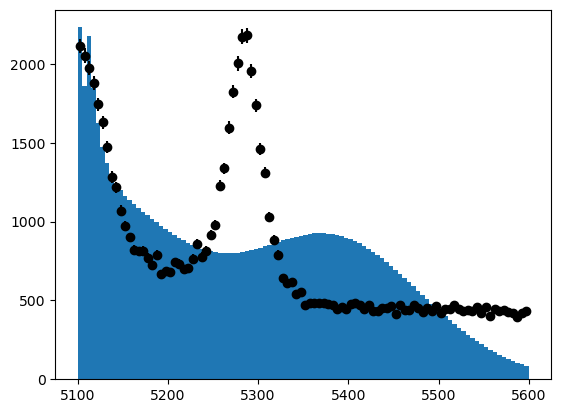

In [8]:
c = cost.ExtendedBinnedNLL(n, xe, cdf)
#parameters for B- meson
m = Minuit(     c,
                norm_mu=5100, 
                norm_sigma=10,
                norm_n=3e2,
                
                comb_mu=5100,
                comb_sigma=10,
                comb_n=1200,

                tau=1/0.33,
                xoffset=5100,
                norm=1,

                total_norm=3e4)

# set bounds on parameters
m.limits['norm_mu'] = (5200, 5400)
m.limits['norm_sigma'] = (1, 100)
m.limits['norm_n'] = (0, 1e4)

m.limits['comb_mu'] = (5100, 5110)
m.limits['comb_sigma'] = (1, 100)
m.limits['comb_n'] = (1, 1e4)

m.scan(ncall=1e6)
#m.interactive()
m.migrad(iterate=20, ncall=1000000).migrad()



/home/aavash/anaconda3/lib/python3.10/site-packages/iminuit/util.py:1297: VisibleDeprecationWarning: Using the `func_code` attribute to dynamically declare parameter names is deprecated, use the attribute `_parameters` instead (a dict of strings to limits)
  warnings.warn(


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.627e+07 (χ²/ndof = 180769.9)│             Nfcn = 61184             │
│ EDM = 370 (Goal: 0.0002)         │            time = 7.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ ABOVE EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name       │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ norm_mu    │ 5.04900e3 │ 0.00008e3 │            │            │         │         │       │
│ 1 │ norm_sigma │   9.899   │   0.016   │            │            │         │         │       │
│ 2 │ norm_n     │232.499440 │ 0.000004  │            │            │         │         │       │
│ 3 │ comb_mu    │ 5.04936e3 │ 0.00012e3 │            │            │         │         │       │
│ 4 │ comb_sigma │   9.818   │   0.022   │            │            │         │         │       │
│ 5 │ comb_n     │48.9967205563│0.0000000021│            │            │         │         │       │
│ 6 │ tau        │12.5146865483│0.0000000013│            │            │         │         │       │
│ 7 │ xoffset    │5.0999999285e3│0.0000000005e3│            │            │         │         │       │
│ 8 │ norm       │990.005380023e-3│0.000000021e-3│            │            │         │         │       │
│ 9 │ total_norm │29.7000003e3│0.0000005e3│            │            │         │         │       │
└───┴────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│            │        norm_mu     norm_sigma         norm_n        comb_mu     comb_sigma         comb_n            tau        xoffset           norm     total_norm │
├────────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│    norm_mu │        0.00565       -0.01e-3              0         -0.000             -0         -0e-18              0             -0        0.4e-21             -0 │
│ norm_sigma │       -0.01e-3       0.000264              0             -0             -0         -0e-18              0             -0        0.1e-21             -0 │
│     norm_n │              0              0       1.83e-11              0              0     -6.074e-15        0.7e-18              0    37.1441e-18      -2.327e-9 │
│    comb_mu │         -0.000             -0              0         0.0132             -0         -0e-18              0             -0        1.6e-21             -0 │
│ comb_sigma │             -0             -0              0             -0       0.000476         -0e-18              0             -0        0.5e-21             -0 │
│     comb_n │         -0e-18         -0e-18     -6.074e-15         -0e-18         -0e-18       4.56e-18             -0         -0e-18      -12.3e-21    774.397e-15 │
│        tau │              0              0        0.7e-18              0              0             -0       1.69e-18        1.1e-18              0      -94.8e-18 │
│    xoffset │             -0       

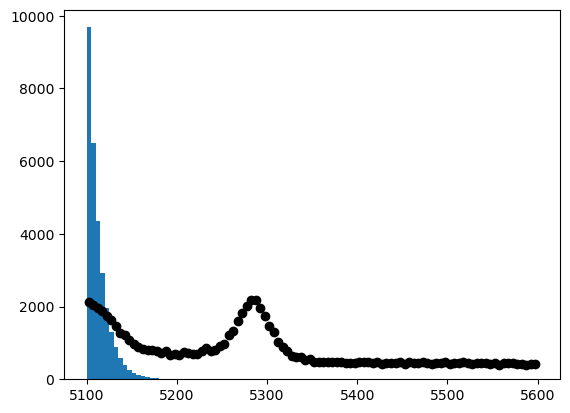

In [9]:
c = cost.ExtendedBinnedNLL(n, xe, cdf)
#parameters for B+ meson
m = Minuit(     c,
                norm_mu=5100, 
                norm_sigma=10,
                norm_n=3e2,
                
                comb_mu=5100,
                comb_sigma=10,
                comb_n=1200,

                tau=1/0.33,
                xoffset=5100,
                norm=1,

                total_norm=3e4)
m.scan(ncall=1e6)
#m.interactive()
m.migrad(iterate=20, ncall=1000000).migrad()
#m.visualize()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.627e+07 (χ²/ndof = 180769.9)│             Nfcn = 61284             │
│ EDM = 1.08e+07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ ABOVE EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name       │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ norm_mu    │ 5.04900e3 │ 0.00009e3 │            │            │         │         │       │
│ 1 │ norm_sigma │   9.899   │   0.018   │            │            │         │         │       │
│ 2 │ norm_n     │232.499440 │ 0.000004  │            │            │         │         │       │
│ 3 │ comb_mu    │ 5.04936e3 │ 0.00014e3 │            │            │         │         │       │
│ 4 │ comb_sigma │   9.818   │   0.028   │            │            │         │         │       │
│ 5 │ comb_n     │48.9967205563│0.0000000021│            │            │         │         │       │
│ 6 │ tau        │12.5146865483│0.0000000013│            │            │         │         │       │
│ 7 │ xoffset    │5.0999999285e3│0.0000000005e3│            │            │         │         │       │
│ 8 │ norm       │990.005380023e-3│0.000000021e-3│            │            │         │         │       │
│ 9 │ total_norm │29.7000003e3│0.0000005e3│            │            │         │         │       │
└───┴────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│            │        norm_mu     norm_sigma         norm_n        comb_mu     comb_sigma         comb_n            tau        xoffset           norm     total_norm │
├────────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│    norm_mu │        0.00812             -0              0         -0.000             -0         -0e-18              0             -0        0.2e-21             -0 │
│ norm_sigma │             -0       0.000332              0             -0             -0         -0e-18              0             -0              0             -0 │
│     norm_n │              0              0       1.83e-11              0              0     -6.074e-15        0.7e-18              0    37.1441e-18      -2.327e-9 │
│    comb_mu │         -0.000             -0              0         0.0192             -0         -0e-18              0             -0        0.8e-21             -0 │
│ comb_sigma │             -0             -0              0             -0        0.00079         -0e-18              0             -0        0.2e-21             -0 │
│     comb_n │         -0e-18         -0e-18     -6.074e-15         -0e-18         -0e-18       4.56e-18             -0         -0e-18      -12.3e-21    774.397e-15 │
│        tau │              0              0        0.7e-18              0              0             -0       1.69e-18        1.1e-18              0      -94.8e-18 │
│    xoffset │             -0       

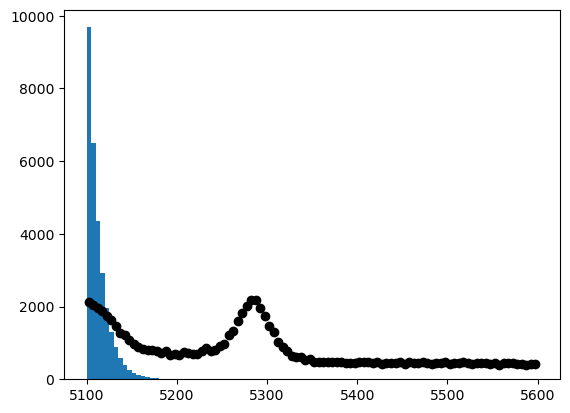

In [10]:
m.hesse()

In [11]:
m.interactive()

In [12]:
m.draw_mnmatrix(cl=[1, 2, 3])

RuntimeError: Function minimum is not valid: <FMin algorithm='Migrad' edm=10784606.65563716 edm_goal=0.0002 errordef=1.0 fval=16269290.44468255 has_accurate_covar=False has_covariance=True has_made_posdef_covar=True has_parameters_at_limit=False has_posdef_covar=False has_reached_call_limit=False has_valid_parameters=False hesse_failed=False is_above_max_edm=True is_valid=False nfcn=61284 ngrad=0 reduced_chi2=180769.8938298061 time=-7.191319941999993>

In [ ]:
p0 = [5100, 11, 1e1, 5300, 12, 1e1, 0.3, 5100, 1, 3e4]
popt, pcov = curve_fit(only_gaussian, bin_centers, bin_heights,
                                        p0=p0,
                                        maxfev=10000000)

/tmp/ipykernel_85623/1063578750.py:34: RuntimeWarning: overflow encountered in exp
  return np.array(decay  * norm * np.exp(-(x-xoffset)*decay) )
/home/aavash/anaconda3/lib/python3.10/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [ ]:

# cost_single_crystal = cost.ExtendedBinnedNLL(n, xe, crystal_signal, verbose=1)


# # m = Minuit(     cost_single_crystal,
# #                 beta=12,
# #                 m=11,
# #                 scale=1e10,
# #                 n=1)
# # m.scan(ncall=1e5)
# # #m.interactive()
# # m


plt.plot(bin_centers, crystal_signal(bin_centers, 10, 11, 1e10, 1), label='Fit')

TypeError: cdf() missing 1 required positional argument: 'scale'

In [13]:

#plot the crystal signal

c_crystal = cost.ExtendedBinnedNLL(n, xe, cdf_crystal)


/home/aavash/anaconda3/lib/python3.10/site-packages/iminuit/util.py:1297: VisibleDeprecationWarning: Using the `func_code` attribute to dynamically declare parameter names is deprecated, use the attribute `_parameters` instead (a dict of strings to limits)
  warnings.warn(


In [273]:
n = Minuit(     c_crystal,
                crystal_beta=5100,
                crystal_m=4,
                crystal_loc=5300,
                crystal_scale=4,
                crystal_norm=3e2,
                
                comb_mu=5100,
                comb_sigma=10,
                comb_n=100,

                tau=1/0.34,
                xoffset=5100,
                norm=1e3,

                total_norm=1e2)
n.interactive()
n.scan(ncall=1e5)
n.limits['crystal_beta'] = (1000, 5400)
n.limits['crystal_m'] = (1, 5)
n.limits['crystal_scale'] = (1, 100)
n.limits['crystal_norm'] = (0, 1e4)

n.limits['comb_mu'] = (5100, 5110)
n.limits['comb_sigma'] = (1, 20)
n.limits['comb_n'] = (1, 1e4)


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 480.6 (χ²/ndof = 2.0)      │             Nfcn = 12505             │
│ EDM = 4.36e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │   Hesse FAILED   │APPROXIMATE│NOT pos. def.│ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name          │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ crystal_beta  │  5.049e3  │  0.000e3  │            │            │  1000   │  5400   │       │
│ 1 │ crystal_m     │   3.96    │   0.00    │            │            │    1    │    5    │       │
│ 2 │ crystal_loc   │  5.284e3  │  0.000e3  │            │            │         │         │       │
│ 3 │ crystal_scale │ 1.8617e1  │ 0.0000e1  │            │            │    1    │   100   │       │
│ 4 │ crystal_norm  │ 2.6883e2  │ 0.0000e2  │            │            │    0    │  10000  │       │
│ 5 │ comb_mu       │  5.11e3   │  0.00e3   │            │            │  5100   │  5110   │       │
│ 6 │ comb_sigma    │    2e1    │    0e1    │            │            │    1    │   20    │       │
│ 7 │ comb_n        │ 2.3834e2  │ 0.0000e2  │            │            │    1    │  10000  │       │
│ 8 │ tau           │ 6.0172e2  │ 0.0000e2  │            │            │         │         │       │
│ 9 │ xoffset       │ 4.8059e3  │ 0.0000e3  │            │            │         │         │       │
│ 10│ norm          │ 3.2226e3  │ 0.0000e3  │            │            │         │         │       │
│ 11│ total_norm    │ 5.1629e1  │ 0.0000e1  │            │            │         │         │       │
└───┴───────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

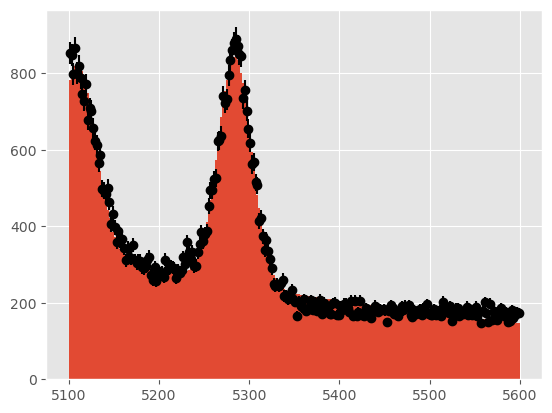

In [45]:
n.migrad(iterate=20, ncall=300000).migrad()


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 480.6 (χ²/ndof = 2.0)      │             Nfcn = 12516             │
│ EDM = 4.36e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │   Hesse FAILED   │APPROXIMATE│NOT pos. def.│ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name          │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ crystal_beta  │  5.049e3  │  0.000e3  │            │            │  1000   │  5400   │       │
│ 1 │ crystal_m     │   3.96    │   0.00    │            │            │    1    │    5    │       │
│ 2 │ crystal_loc   │  5.284e3  │  0.000e3  │            │            │         │         │       │
│ 3 │ crystal_scale │ 1.8617e1  │ 0.0000e1  │            │            │    1    │   100   │       │
│ 4 │ crystal_norm  │ 2.6883e2  │ 0.0000e2  │            │            │    0    │  10000  │       │
│ 5 │ comb_mu       │  5.11e3   │  0.00e3   │            │            │  5100   │  5110   │       │
│ 6 │ comb_sigma    │    2e1    │    0e1    │            │            │    1    │   20    │       │
│ 7 │ comb_n        │ 2.3834e2  │ 0.0000e2  │            │            │    1    │  10000  │       │
│ 8 │ tau           │ 6.0172e2  │ 0.0000e2  │            │            │         │         │       │
│ 9 │ xoffset       │ 4.8059e3  │ 0.0000e3  │            │            │         │         │       │
│ 10│ norm          │ 3.2226e3  │ 0.0000e3  │            │            │         │         │       │
│ 11│ total_norm    │ 5.1629e1  │ 0.0000e1  │            │            │         │         │       │
└───┴───────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

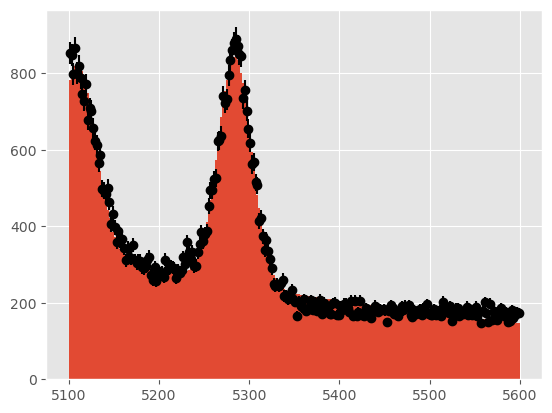

In [46]:
n.hesse()

# Crystal B+

In [13]:
data_plus = np.genfromtxt("/home/aavash/Downloads/data_from_lab/from_todor/inv_mass_filtered_Bplus .csv", delimiter=",")

#take only data from 5100 to 5400
data_plus = data_plus[(data_plus > 5100) & (data_plus < 5600)]
n_plus, xe_plus = np.histogram(data_plus, bins=100)
c_crystal_plus = cost.ExtendedBinnedNLL(n_plus, xe_plus, cdf_crystal)

/home/aavash/anaconda3/lib/python3.10/site-packages/iminuit/util.py:1297: VisibleDeprecationWarning: Using the `func_code` attribute to dynamically declare parameter names is deprecated, use the attribute `_parameters` instead (a dict of strings to limits)
  warnings.warn(


In [15]:
n_plus_c = Minuit(     c_crystal_plus,
                crystal_beta=1.2,
                crystal_m=5,
                crystal_loc=5300,
                crystal_scale=4,
                crystal_norm=277,
                
                comb_mu=5100,
                comb_sigma=10,
                comb_n=100,

                tau=1500,
                xoffset=4100,
                norm=1e3,

                total_norm=1e2)
n_plus_c.limits['crystal_m'] = (0, 20)
n_plus_c.limits['crystal_scale'] = (1, 100)
n_plus_c.limits['crystal_norm'] = (1, 1e4)
n_plus_c.limits['crystal_loc'] = (5200, 5400)

n_plus_c.limits['comb_mu'] = (5100, 5101)
n_plus_c.limits['comb_sigma'] = (1, 50)
n_plus_c.limits['comb_n'] = (1, 1e4)

n_plus_c.fixed["crystal_beta"] = True
n_plus_c.fixed["comb_mu"] = True


In [134]:
n_plus_c.migrad(iterate=20, ncall=300000).migrad()
n_plus_c.interactive()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 90.93 (χ²/ndof = 1.0)      │             Nfcn = 4665              │
│ EDM = 2.46e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name          │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ crystal_beta  │   1.200   │   0.012   │            │            │         │         │  yes  │
│ 1 │ crystal_m     │    3.1    │    0.6    │            │            │    0    │   20    │       │
│ 2 │ crystal_loc   │ 5.28387e3 │ 0.00027e3 │            │            │  5200   │  5400   │       │
│ 3 │ crystal_scale │   20.68   │   0.29    │            │            │    1    │   100   │       │
│ 4 │ crystal_norm  │    161    │     8     │            │            │    1    │  10000  │       │
│ 5 │ comb_mu       │  5.10e3   │  0.05e3   │            │            │  5100   │  5101   │  yes  │
│ 6 │ comb_sigma    │   39.7    │    1.4    │            │            │    1    │   50    │       │
│ 7 │ comb_n        │   49.6    │    2.9    │            │            │    1    │  10000  │       │
│ 8 │ tau           │  1.79e3   │  0.10e3   │            │            │         │         │       │
│ 9 │ xoffset       │  5.45e3   │  0.11e3   │            │            │         │         │       │
│ 10│ norm          │  1.46e3   │  0.09e3   │            │            │         │         │       │
│ 11│ total_norm    │    115    │     6     │            │            │         │         │       │
└───┴───────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│               │  crystal_beta     crystal_m   crystal_loc crystal_scale  crystal_norm       comb_mu    comb_sigma        comb_n           tau       xoffset          norm    total_norm │
├───────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│  crystal_beta │             0           0.0          0.00          0.00             0             0           0.0             0             0             0           0e3             0 │
│     crystal_m │           0.0         0.414         -0.04          0.04          -1.6           0.0           0.5           0.7         -18.8          -6.0          -4.9          -0.3 │
│   crystal_loc │          0.00         -0.04        0.0729         -0.02          0.15          0.00         -0.05         -0.07         -0.63         -0.34         -0.27         -0.00 │
│ crystal_scale │          0.00          0.04         -0.02        0.0834         -0.02          0.00          0.07          0.11          5.57          1.83          1.49          0.07 │
│  crystal_norm │             0          -1.6          0.15         -0.02          66.9             0          -2.5            14           -30           290           240 

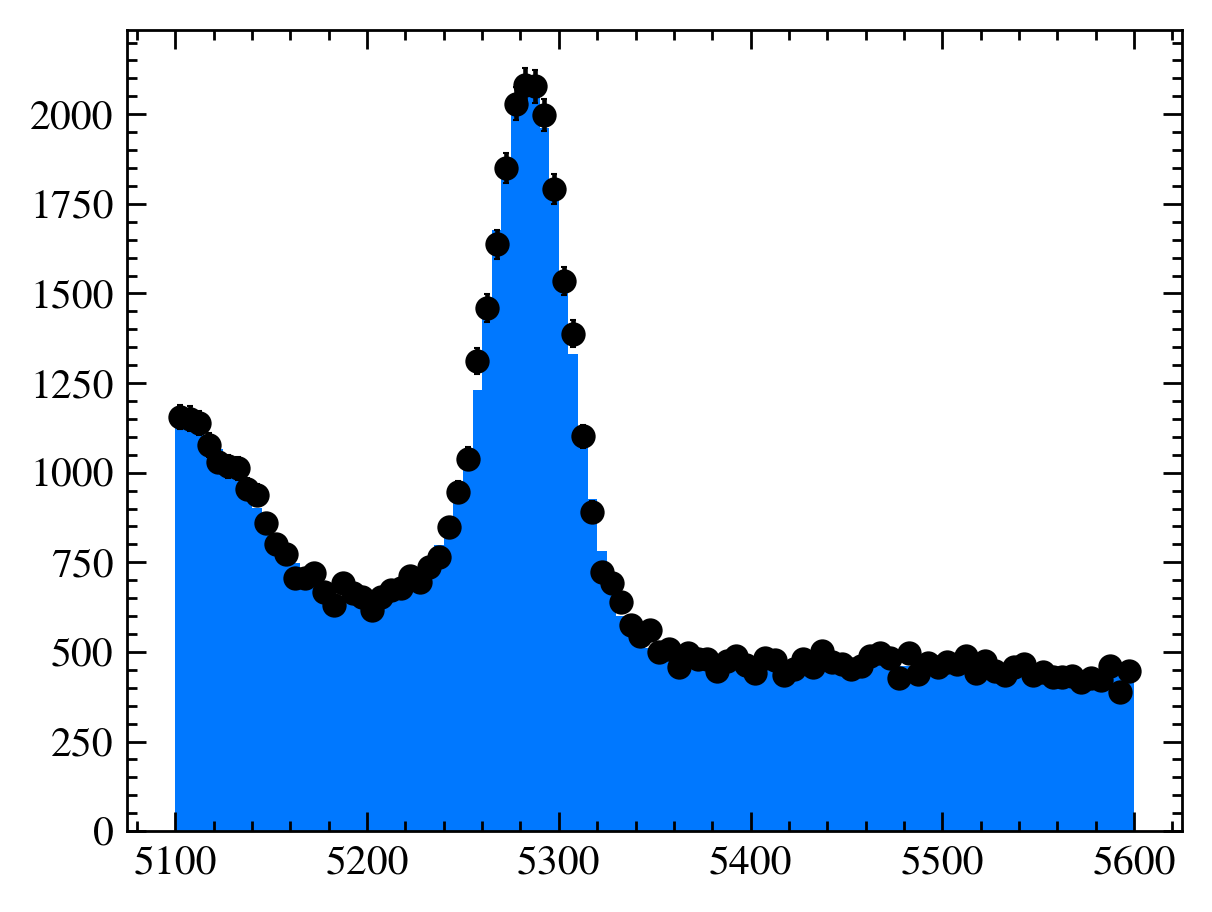

In [135]:
n_plus_c.hesse()

In [138]:
n_plus_c.values

<ValueView crystal_beta=1.2 crystal_m=3.066800708293673 crystal_loc=5283.866200116772 crystal_scale=20.679652920238063 crystal_norm=160.86015229246274 comb_mu=5100.0 comb_sigma=39.655464997831636 comb_n=49.60017226349429 tau=1790.5418729507896 xoffset=5448.500996131521 norm=1459.50922801066 total_norm=114.93992817147347>

## Using this sub into curve_fit

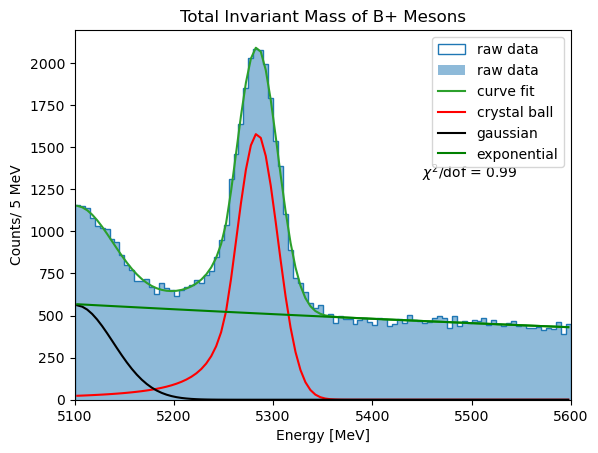

In [31]:

np.random.seed(42)
popt, pcov = fit_curve_post_minut(data_plus, 
                                  [1.2, 3.066800708293673, 5283.866200116772,
                                    20.679652920238063,160.86015229246274,
                                    5100, 39.65547, 49.60, 1790.5, 5448.5,
                                    1459, 114.939])

hist_raw = plt.hist(data_plus, bins=100, label="raw data", color="C0", alpha=0.5)
bin_centers = 0.5 * (hist_raw[1][1:] + hist_raw[1][:-1])
bin_heights = hist_raw[0]

crystal_part = crystalball.pdf(bin_centers, popt[0], popt[1], popt[2], popt[3]) * popt[4] * popt[-1]
comb_part = norm.pdf(bin_centers, popt[5], popt[6]) * popt[7] * popt[-1]
exp_part = expon.pdf(bin_centers, popt[8], popt[9]) * popt[10] * popt[-1]

total_part_plus = crystal_part + comb_part + exp_part

#plot the fit
plt.plot(bin_centers, fit_crystal(bin_centers, *popt), label="curve fit", color="C2")
plt.plot(bin_centers, crystal_part, label="crystal ball", color="red")
plt.plot(bin_centers, comb_part, label="gaussian", color="black")
plt.plot(bin_centers, exp_part, label="exponential", color="green")

#add labels 
plt.xlabel("Energy [MeV]")
plt.ylabel("Counts/ 5 MeV")

#calculate the chi squared per degree of freedom
chi_squared = np.sum((fit_crystal(bin_centers, *popt) - bin_heights)**2 / bin_heights)
fixed_params = 2
dof = len(bin_heights) - len(popt) + fixed_params
reduced_chi_squared = chi_squared / dof

#add the chi-squared per degree of freedom on the plot
plt.text(0.7, 0.6, r"$\chi^2$/dof = {:.2f}".format(reduced_chi_squared), transform=plt.gca().transAxes)
#increase size of text
#add title
plt.title("Total Invariant Mass of B+ Mesons")
plt.xlim(5100, 5600)

plt.legend()



In [32]:
#print popt with the name of the parameter
for i, name in enumerate(["crystal_beta", "crystal_m", "crystal_loc", "crystal_scale", "crystal_norm",
                            "comb_mu", "comb_sigma", "comb_n", "tau", "xoffset", "norm", "total_norm"]):
        print(name, popt[i])
    

crystal_beta 1.3591473456114556
crystal_m 1.7136619831409403
crystal_loc 5283.771771974418
crystal_scale 20.89514106030984
crystal_norm 428.17557852718426
comb_mu 5100.882259614373
comb_sigma 37.84619981109058
comb_n 230.89206535873095
tau 4764.954966854947
xoffset 1800.8502954146313
norm 5343.495381380866
total_norm 230.62492224314707


Number of events:  92851.16029412799


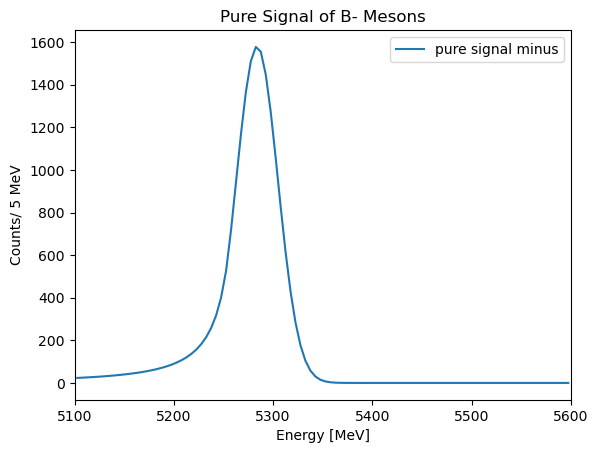

In [33]:
pure_signal_plus = total_part_plus - comb_part - exp_part

#plot the pure signal
plt.figure()
plt.plot(bin_centers, pure_signal_plus, label="pure signal minus")
plt.xlabel("Energy [MeV]")
plt.ylabel("Counts/ 5 MeV")
plt.title("Pure Signal of B- Mesons")
plt.xlim(5100, 5600)
plt.legend()

#integrate the pure signal to get the number of events
number_of_events_plus = np.trapz(pure_signal_plus, bin_centers)
print("Number of events: ", number_of_events_plus)

# Crystal B-

In [7]:
data_minus = np.genfromtxt('/home/aavash/Downloads/data_from_lab/from_todor/inv_mass_filtered_Bminus.csv', delimiter=',')
data_minus = data_minus[(data_minus > 5100) & (data_minus < 5600)]
n_minus, xe_minus = np.histogram(data_minus, bins=100)
c_crystal_minus = cost.ExtendedBinnedNLL(n_minus, xe_minus, cdf_crystal)

/home/aavash/anaconda3/lib/python3.10/site-packages/iminuit/util.py:1297: VisibleDeprecationWarning: Using the `func_code` attribute to dynamically declare parameter names is deprecated, use the attribute `_parameters` instead (a dict of strings to limits)
  warnings.warn(


In [21]:
n_minus_c = Minuit(     c_crystal_minus,
                crystal_beta=1.2,
                crystal_m=5,
                crystal_loc=5300,
                crystal_scale=4,
                crystal_norm=277,
                
                comb_mu=5100,
                comb_sigma=10,
                comb_n=100,

                tau=1500,
                xoffset=4100,
                norm=1e3,

                total_norm=1e2)
n_minus_c.limits['crystal_m'] = (0, 20)
n_minus_c.limits['crystal_scale'] = (1, 100)
n_minus_c.limits['crystal_norm'] = (1, 1e4)
n_minus_c.limits['crystal_loc'] = (5200, 5400)

n_minus_c.limits['comb_mu'] = (5100, 5101)
n_minus_c.limits['comb_sigma'] = (1, 50)
n_minus_c.limits['comb_n'] = (1, 1e4)

n_minus_c.fixed["crystal_beta"] = True
n_minus_c.fixed["comb_mu"] = True


In [22]:
n_minus_c.migrad(iterate=20, ncall=300000).migrad()
n_minus_c.interactive()

/tmp/ipykernel_5944/3727083308.py:32: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "cdf_crystal" failed type inference due to: Untyped global name 'combinatorial': Cannot determine Numba type of <class 'function'>

File "../../../../tmp/ipykernel_5944/3727083308.py", line 40:
<source missing, REPL/exec in use?>

  @jit
/home/aavash/anaconda3/lib/python3.10/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "cdf_crystal" was compiled in object mode without forceobj=True.

File "../../../../tmp/ipykernel_5944/3727083308.py", line 32:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaWarning(warn_msg,
/home/aavash/anaconda3/lib/python3.10/site-packages/numba/core/object_mode_passes.py:161: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit https://numba.readthedocs.

# Using Scipy

In [23]:
n_minus_c.values

<ValueView crystal_beta=1.2 crystal_m=2.432499812292679 crystal_loc=5284.267727297867 crystal_scale=19.917603469642874 crystal_norm=1280.2581954401385 comb_mu=5100.0 comb_sigma=38.68306145920468 comb_n=375.09474794320636 tau=1843.8714314642468 xoffset=15835.941551921182 norm=40.11694596995858 total_norm=14.638833875530139>

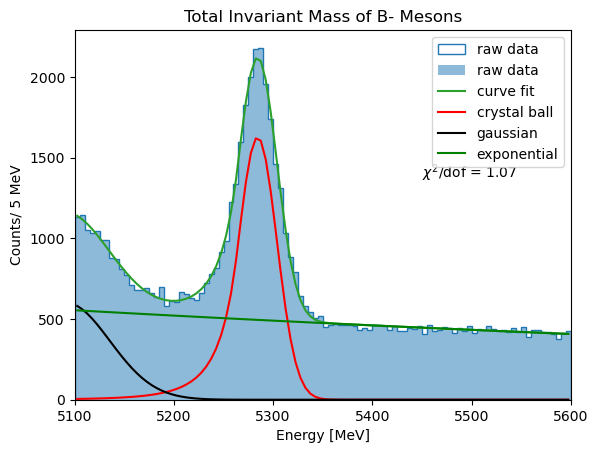

In [38]:
np.random.seed(42)

popt, pcov = fit_curve_post_minut(data_minus, 
                                  [1.2, 2.4305106544310937, 5284.267564310806, 19.91862060366487, 1279.7396377483892,
                                   5100.0, 38.68589943165767, 374.95086012266245, 1846.0080166945863,
                                   15841.919008974444, 40.270404679374394, 14.647764314618723])

hist_raw = plt.hist(data_minus, bins=100, label="raw data", color="C0", alpha=0.5)
bin_centers = 0.5 * (hist_raw[1][1:] + hist_raw[1][:-1])
bin_heights = hist_raw[0]

crystal_part = crystalball.pdf(bin_centers, popt[0], popt[1], popt[2], popt[3]) * popt[4] * popt[-1]
comb_part = norm.pdf(bin_centers, popt[5], popt[6]) * popt[7] * popt[-1]
exp_part = expon.pdf(bin_centers, popt[8], popt[9]) * popt[10] * popt[-1]

total_part_minus = crystal_part + comb_part + exp_part
#plot the fit
plt.plot(bin_centers, fit_crystal(bin_centers, *popt), label="curve fit", color="C2")
plt.plot(bin_centers, crystal_part, label="crystal ball", color="red")
plt.plot(bin_centers, comb_part, label="gaussian", color="black")
plt.plot(bin_centers, exp_part, label="exponential", color="green")

#add labels 
plt.xlabel("Energy [MeV]")
plt.ylabel("Counts/ 5 MeV")

#calculate the chi squared per degree of freedom
chi_squared = np.sum((fit_crystal(bin_centers, *popt) - bin_heights)**2 / bin_heights)
fixed_params = 2
dof = len(bin_heights) - len(popt) + fixed_params
reduced_chi_squared = chi_squared / dof

#add the chi-squared per degree of freedom on the plot
plt.text(0.7, 0.6, r"$\chi^2$/dof = {:.2f}".format(reduced_chi_squared), transform=plt.gca().transAxes)
#increase size of text
#add title
plt.title("Total Invariant Mass of B- Mesons")
plt.xlim(5100, 5600)

plt.legend()



In [39]:
#print popt with the name of the parameter
for i, name in enumerate(["crystal_beta", "crystal_m", "crystal_loc", "crystal_scale", "crystal_norm",
                            "comb_mu", "comb_sigma", "comb_n", "tau", "xoffset", "norm", "total_norm"]):
        print(name, popt[i])

crystal_beta 1.0786470855146197
crystal_m 5.1912233575597035
crystal_loc 5284.357117241887
crystal_scale 19.363484485715908
crystal_norm 5238.7753334222325
comb_mu 5090.730219873601
comb_sigma 44.586454098836796
comb_n 3998.705247673896
tau 16154.794358880972
xoffset 1618.4584397832098
norm 57.65092178259759
total_norm 16.82290622173942


Number of events:  87826.4040542576


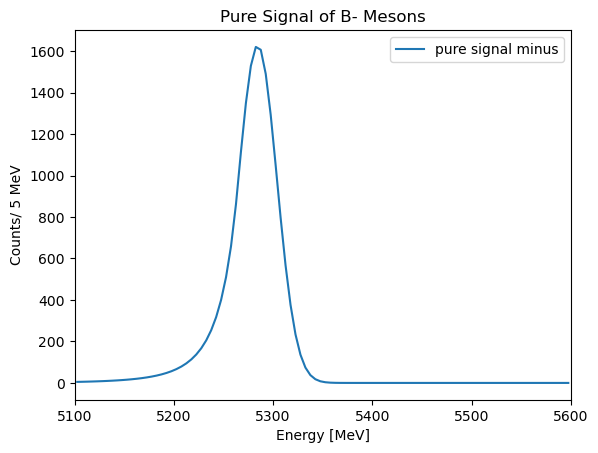

In [40]:
pure_signal_minus = total_part_minus - comb_part - exp_part

#plot the pure signal
plt.figure()
plt.plot(bin_centers, pure_signal_minus, label="pure signal minus")
plt.xlabel("Energy [MeV]")
plt.ylabel("Counts/ 5 MeV")
plt.title("Pure Signal of B- Mesons")
plt.xlim(5100, 5600)
plt.legend()

#integrate the pure signal to get the number of events
number_of_events_minus = np.trapz(pure_signal_minus, bin_centers)
print("Number of events: ", number_of_events_minus)

In [41]:
print("Number of events: ", number_of_events_minus)
print("Number of events: ", number_of_events_plus)

assymetry = (number_of_events_plus - number_of_events_minus) / (number_of_events_plus + number_of_events_minus)
unc_assymetry = np.sqrt((1 - assymetry**2) / (number_of_events_minus + number_of_events_minus))

print("Assymetry: ", assymetry)
print("Uncertainty of assymetry: ", unc_assymetry)


Number of events:  87826.4040542576
Number of events:  92851.16029412799
Assymetry:  0.02781062639399747
Uncertainty of assymetry:  0.0023850881686053203


# Raw Invariant Mass

In [154]:
raw_data = np.genfromtxt('/home/aavash/Downloads/data_from_lab/from_todor/inv_mass_filtered.csv', delimiter=',')#
#select raw_data where the value is greater than 5100
raw_data = raw_data[raw_data > 5100]
#select raw_data where the value is less than 5600
raw_data = raw_data[raw_data < 5600]

In [7]:
n_raw_data, xe_raw = np.histogram(raw_data, bins=100)
cost_raw = cost.ExtendedBinnedNLL(n_raw_data, xe_raw, cdf_crystal)

/home/aavash/anaconda3/lib/python3.10/site-packages/iminuit/util.py:1297: VisibleDeprecationWarning: Using the `func_code` attribute to dynamically declare parameter names is deprecated, use the attribute `_parameters` instead (a dict of strings to limits)
  warnings.warn(


In [33]:
n_raw = Minuit(     cost_raw,
                crystal_beta=1.2,
                crystal_m=5,
                crystal_loc=5300,
                crystal_scale=4,
                crystal_norm=277,
                
                comb_mu=5100,
                comb_sigma=10,
                comb_n=100,

                tau=1500,
                xoffset=4100,
                norm=1e3,

                total_norm=1e2)
#n_raw.scan(ncall=1e5)
#n_raw.limits['crystal_beta'] = (1.0, 1.45)
n_raw.limits['crystal_m'] = (0, 20)
n_raw.limits['crystal_scale'] = (1, 100)
n_raw.limits['crystal_norm'] = (1, 1e4)
n_raw.limits['crystal_loc'] = (5200, 5400)

n_raw.limits['comb_mu'] = (5100, 5101)
n_raw.limits['comb_sigma'] = (1, 50)
n_raw.limits['comb_n'] = (1, 1e4)

n_raw.fixed["crystal_beta"] = True
n_raw.fixed["comb_mu"] = True


#fix parameters
#n_raw.fixed["comb_mu"] = True

┌─────────────────────────────────────────────────────────────────────────┐
│                           SciPy[L-BFGS-B]                               │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 109.7 (χ²/ndof = 1.2)      │             Nfcn = 3783              │
│ EDM = 3.66e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name          │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ crystal_beta  │   1.200   │   0.012   │            │            │         │         │  yes  │
│ 1 │ crystal_m     │   2.70    │   0.32    │            │            │    0    │   20    │       │
│ 2 │ crystal_loc   │ 5.28407e3 │ 0.00019e3 │            │            │  5200   │  5400   │       │
│ 3 │ crystal_scale │   20.31   │   0.20    │            │            │    1    │   100   │       │
│ 4 │ crystal_norm  │    462    │    17     │            │            │    1    │  10000  │       │
│ 5 │ comb_mu       │  5.10e3   │  0.05e3   │            │            │  5100   │  5101   │  yes  │
│ 6 │ comb_sigma    │   39.2    │    1.0    │            │            │    1    │   50    │       │
│ 7 │ comb_n        │    139    │     6     │            │            │    1    │  10000  │       │
│ 8 │ tau           │  1.822e3  │  0.026e3  │            │            │         │         │       │
│ 9 │ xoffset       │  8.97e3   │  0.08e3   │            │            │         │         │       │
│ 10│ norm          │    599    │    27     │            │            │         │         │       │
│ 11│ total_norm    │   80.6    │    2.8    │            │            │         │         │       │
└───┴───────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│               │  crystal_beta     crystal_m   crystal_loc crystal_scale  crystal_norm       comb_mu    comb_sigma        comb_n           tau       xoffset          norm    total_norm │
├───────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│  crystal_beta │             0           0.0         0.000          0.00             0             0             0             0             0           0e3             0             0 │
│     crystal_m │           0.0         0.103        -0.015          0.02         -1.81           0.0          0.19          0.76         -0.85         -0.47         -0.18         -0.04 │
│   crystal_loc │         0.000        -0.015         0.035        -0.009         0.225         0.000        -0.020        -0.091        -0.035        -0.082        -0.026         0.002 │
│ crystal_scale │          0.00          0.02        -0.009        0.0388         -0.03          0.00          0.03          0.13          0.36          0.23          0.09          0.01 │
│  crystal_norm │             0         -1.81         0.225         -0.03           289             0          -3.6            60       -0.06e3        0.38e3        0.12e3 

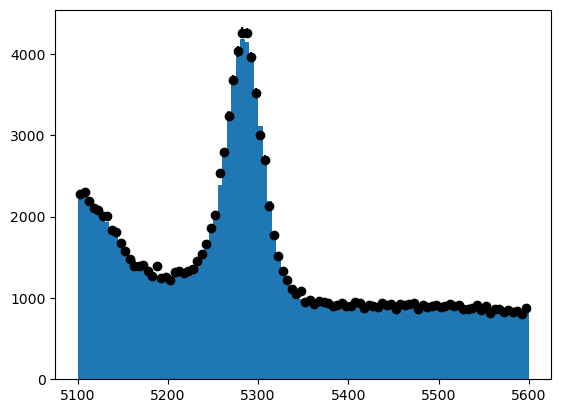

In [60]:
n_raw.interactive()
#n_raw.migrad(iterate=20, ncall=100000)
n_raw.scipy()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 116.6 (χ²/ndof = 1.3)      │             Nfcn = 3752              │
│ EDM = 6.28e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name          │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ crystal_beta  │   1.440   │   0.014   │            │            │  1.44   │  1.45   │  yes  │
│ 1 │ crystal_m     │ 902.41e-3 │  0.11e-3  │            │            │    0    │   20    │       │
│ 2 │ crystal_loc   │ 5.28383e3 │ 0.00018e3 │            │            │  5200   │  5400   │       │
│ 3 │ crystal_scale │   20.77   │   0.19    │            │            │    1    │   100   │       │
│ 4 │ crystal_norm  │    7.6    │    0.5    │            │            │    1    │  10000  │       │
│ 5 │ comb_mu       │  5.10e3   │  0.05e3   │            │            │  5100   │  5101   │  yes  │
│ 6 │ comb_sigma    │   36.2    │    0.7    │            │            │    1    │   50    │       │
│ 7 │ comb_n        │    139    │     5     │            │            │    1    │  10000  │       │
│ 8 │ tau           │  2.398e3  │  0.032e3  │            │            │         │         │       │
│ 9 │ xoffset       │  9.76e3   │  0.09e3   │            │            │         │         │       │
│ 10│ norm          │    980    │    40     │            │            │         │         │       │
│ 11│ total_norm    │   73.6    │    2.1    │            │            │         │         │       │
└───┴───────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│               │  crystal_beta     crystal_m   crystal_loc crystal_scale  crystal_norm       comb_mu    comb_sigma        comb_n           tau       xoffset          norm    total_norm │
├───────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│  crystal_beta │             0             0         0.000          0.00          0.00             0           0.0             0           0e3           0e3             0             0 │
│     crystal_m │             0      1.28e-08     -0.112e-6      0.673e-6    -52.649e-6             0     -0.388e-6    127.685e-6   -237.883e-6    765.181e-6    318.005e-6    -68.917e-6 │
│   crystal_loc │         0.000     -0.112e-6        0.0325        -0.007        -0.000         0.000         0.004         0.015        -0.130        -0.119        -0.049        -0.002 │
│ crystal_scale │          0.00      0.673e-6        -0.007        0.0367          0.00          0.00          0.00          0.02          0.42          0.19          0.08          0.01 │
│  crystal_norm │          0.00    -52.649e-6        -0.000          0.00         0.263          0.00         -0.00          0.26         -0.44          1.64          0.68 

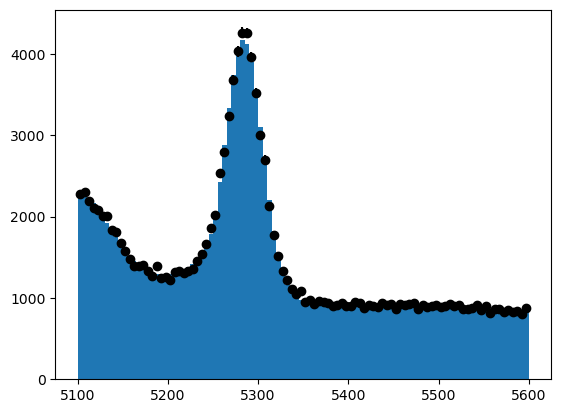

In [28]:
n_raw.hesse()

In [11]:
fitted_vals = n_raw.values

In [12]:
for i in range(0, len(fitted_vals)):
    print(fitted_vals[i])

1.44
0.9016388683538389
5283.82984664044
20.766004000055915
5.652818913815007
5100.0
36.16365648906954
70.1588199774428
2401.889257115558
6167.742887601815
2226.501100144111
145.30483773829917


In [14]:
n_raw.values

<ValueView crystal_beta=1.44 crystal_m=0.9016388683538389 crystal_loc=5283.82984664044 crystal_scale=20.766004000055915 crystal_norm=5.652818913815007 comb_mu=5100.0 comb_sigma=36.16365648906954 comb_n=70.1588199774428 tau=2401.889257115558 xoffset=6167.742887601815 norm=2226.501100144111 total_norm=145.30483773829917>

In [ ]:
class Plotter:
    def __init__(self, cost):
        self.cost = cost

    def __call__(self, args):
        xe = self.cost.xe
        n = self.cost.data
        cx = 0.5 * (xe[1:] + xe[:-1])
        plt.errorbar(cx, n, n ** 0.5, fmt="ok")
        sm = np.diff(self.cost.scaled_cdf(xe, *args[:4], 0, 0, 0))
        bm = np.diff(self.cost.scaled_cdf(xe, 0, *args[1:]))
        plt.stairs(bm, xe, fill=True, color="C1")
        plt.stairs(bm + sm, xe, baseline = bm, fill=True, color="C0")


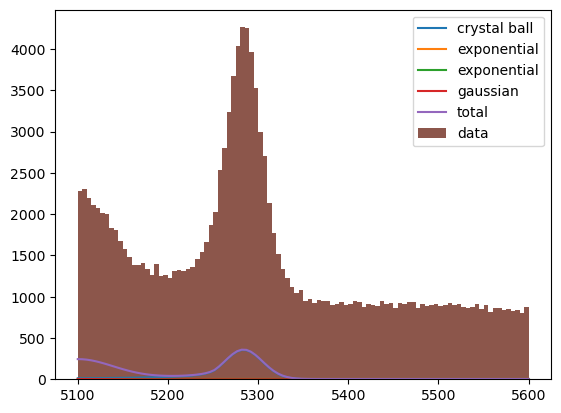

In [41]:
#plot the indivual components
#plot the crystal ball
x = np.linspace(5100, 5600, 100)

#plot the crystal ball 
crystal_component = crystalball.pdf(x, fitted_vals["crystal_beta"], fitted_vals["crystal_m"], fitted_vals["crystal_loc"], fitted_vals["crystal_scale"]) * (
                    fitted_vals["crystal_norm"])
exponential_component = expon.pdf(x, n_raw.values["tau"], n_raw.values["xoffset"]) * n_raw.values["norm"]
gaussian_component = halfnorm.pdf(x, n_raw.values["comb_mu"], n_raw.values["comb_sigma"]) * n_raw.values["comb_n"]

total_normalisation = n_raw.values["total_norm"] 
plt.plot(x, crystal_component*total_normalisation, label="crystal ball")
plt.plot(x, exponential_component*total_normalisation, label="exponential")
plt.plot(x, exponential_component, label="exponential")
plt.plot(x, gaussian_component, label="gaussian")
plt.plot(x, (crystal_component + exponential_component + gaussian_component)*n_raw.values["total_norm"] , label="total")

#plot the actual data
plt.hist(raw_data, bins=100, label="data");
plt.legend()


In [ ]:
#use this to get the curve fit values 

In [245]:
from scipy.stats import crystalball, expon, norm

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 128.9 (χ²/ndof = 1.4)      │             Nfcn = 11070             │
│ EDM = 0.000825 (Goal: 0.0002)    │            time = 0.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name          │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ crystal_beta  │  1.4400   │  0.0021   │            │            │  1.44   │  1.45   │  yes  │
│ 1 │ crystal_m     │   1.20    │   0.14    │            │            │    0    │   20    │       │
│ 2 │ crystal_loc   │ 5.28381e3 │ 0.00018e3 │            │            │  5200   │  5400   │       │
│ 3 │ crystal_scale │   20.58   │   0.21    │            │            │    1    │   100   │       │
│ 4 │ crystal_norm  │  0.61e3   │  0.28e3   │            │            │    1    │  10000  │       │
│ 5 │ comb_mu       │ 5.10100e3 │ 0.00019e3 │            │            │  5100   │  5101   │  yes  │
│ 6 │ comb_sigma    │   35.3    │    1.0    │            │            │    1    │   50    │       │
│ 7 │ comb_n        │    120    │    50     │            │            │    1    │  10000  │       │
│ 8 │ tau           │   1.8e3   │   0.2e3   │            │            │         │         │       │
│ 9 │ xoffset       │   6.4e3   │   1.5e3   │            │            │         │         │       │
│ 10│ norm          │   2.4e3   │   1.5e3   │            │            │         │         │       │
│ 11│ total_norm    │    82     │    33     │            │            │         │         │       │
└───┴───────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│               │  crystal_beta     crystal_m   crystal_loc crystal_scale  crystal_norm       comb_mu    comb_sigma        comb_n           tau       xoffset          norm    total_norm │
├───────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│  crystal_beta │             0          0.00         0.000          0.00             0             0           0.0             0             0             0             0             0 │
│     crystal_m │          0.00        0.0199        -0.002        -0.006       -19.265          0.00         0.041         0.190       -19.150       -22.341        -6.011        -0.088 │
│   crystal_loc │         0.000        -0.002        0.0338        -0.008         2.267         0.000        -0.017        -0.018        -2.686        -0.226        -3.530        -0.054 │
│ crystal_scale │          0.00        -0.006        -0.008        0.0462          5.65          0.00          0.04          0.02         18.98         13.72         14.03          0.18 │
│  crystal_norm │             0       -19.265         2.267          5.65      7.96e+04             0         -45.3        12.1e3        0.02e6        0.28e6       -0.10e6 

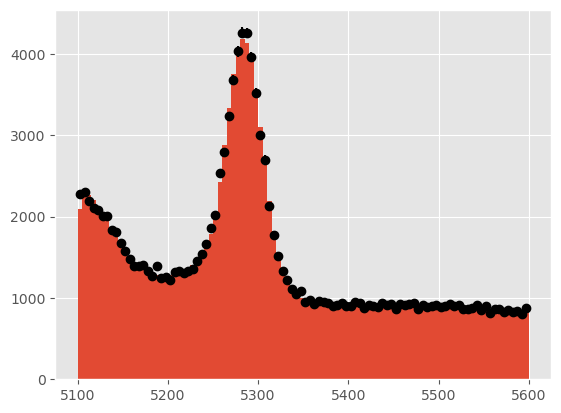

In [242]:
n_raw.hesse()

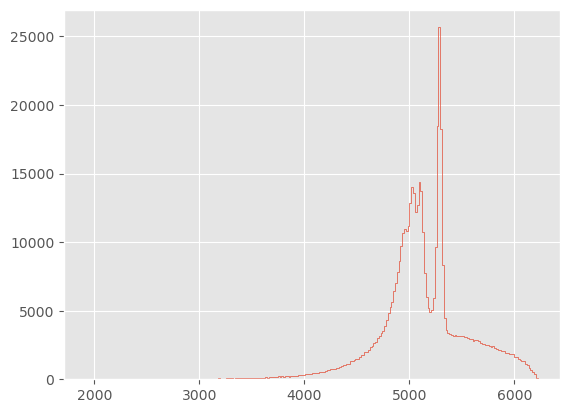

In [73]:
#plot the raw data histogram
plt.hist(raw_data, bins=250, histtype='step', label='raw data');

In [75]:
print(np.shape(raw_data))

(512257,)


In [169]:
#fit with gaussian
n_raw, xe_raw = np.histogram(raw_data, bins=250)

cost_raw_gaussian = cost.ExtendedBinnedNLL(n_raw, xe_raw, cdf)

#parameters for B- meson
n_raw_gaussian = Minuit( cost_raw_gaussian,
                norm_mu=5300, 
                norm_sigma=10,
                norm_n=3e2,
                
                comb_mu=5100,
                comb_sigma=10,
                comb_n=1200,

                tau=1/0.33,
                xoffset=5100,
                norm=1,

                total_norm=3e4)


/home/aavash/anaconda3/lib/python3.10/site-packages/iminuit/util.py:1297: VisibleDeprecationWarning: Using the `func_code` attribute to dynamically declare parameter names is deprecated, use the attribute `_parameters` instead (a dict of strings to limits)
  warnings.warn(


In [170]:

# set bounds on parameters
n_raw_gaussian.limits['norm_mu'] = (5200, 5400)
n_raw_gaussian.limits['norm_sigma'] = (1, 100)
n_raw_gaussian.limits['norm_n'] = (10, 1e2)

n_raw_gaussian.limits['comb_mu'] = (5100, 5110)
n_raw_gaussian.limits['comb_sigma'] = (1, 100)
n_raw_gaussian.limits['comb_n'] = (10, 1e2)

#n_raw_gaussian.scan(ncall=1e6)
n_raw_gaussian.interactive()
#n_raw_gaussian.migrad(iterate=20, ncall=1000000).migrad()

/home/aavash/anaconda3/lib/python3.10/site-packages/iminuit/cost.py:1147: RuntimeWarning: overflow encountered in multiply
  d = self._model(self._model_xe, *args)
/home/aavash/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:1292: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


/home/aavash/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:1292: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


In [123]:
def fit_curve_post_minut(data, p0_vals):
    #fit the data with a gaussian
    hist_raw = plt.hist(data, bins=100, histtype='step', label='raw data');
    bin_centers = 0.5 * (hist_raw[1][1:] + hist_raw[1][:-1])
    bin_heihgts = hist_raw[0]
    popt, pcov = curve_fit(fit_crystal, bin_centers, bin_heihgts, p0=p0_vals)
    plt.xlim(5100, 5600)
    plt.clf()

    return popt, pcov

In [94]:
import mplhep as hep
hep.style.use("LHCb2")

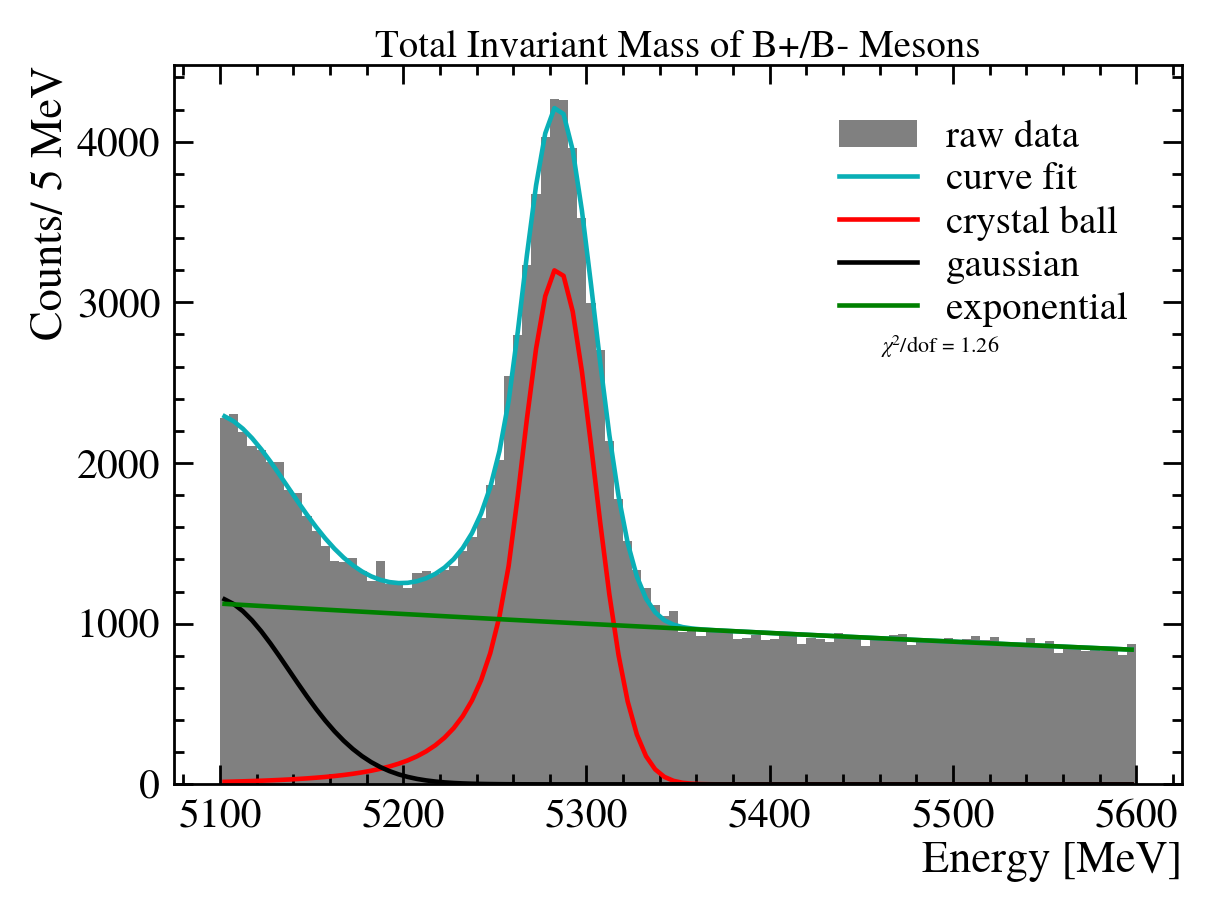

In [104]:
#using curve fit
def fit_crystal(x, beta, m , loc, scale, c_norm, 
                comb_mu, comb_sigma, comb_n,
                tau, xoffset, exp_norm, total_norm
                ):
    crystal_val = crystalball.pdf(x, beta, m, loc, scale) * c_norm
    comb_val = norm.pdf(x, comb_mu, comb_sigma) * comb_n
    exp_val = expon.pdf(x, tau, xoffset) * exp_norm
    return (crystal_val + comb_val + exp_val) * total_norm

#fit the data

#get bin centers from raw_dat

hist_raw = plt.hist(raw_data, bins=100, label='raw data', color="grey");

bin_centers = 0.5 * (hist_raw[1][1:] + hist_raw[1][:-1])
bin_heights = hist_raw[0]
#fix the beta parameter

popt, pcov = curve_fit(fit_crystal, bin_centers, bin_heights, p0=[1.2, 5, 5300, 4, 277, 5100, 10, 100, 1500, 4100, 1e3, 1e2])

crystal_part = crystalball.pdf(bin_centers, popt[0], popt[1], popt[2], popt[3]) * popt[4] * popt[-1]
comb_part = norm.pdf(bin_centers, popt[5], popt[6]) * popt[7] * popt[-1]
exp_part = expon.pdf(bin_centers, popt[8], popt[9]) * popt[10] * popt[-1]

#plot the fit
plt.plot(bin_centers, fit_crystal(bin_centers, *popt), label="curve fit", color="C2")
plt.plot(bin_centers, crystal_part, label="crystal ball", color="red")
plt.plot(bin_centers, comb_part, label="gaussian", color="black")
plt.plot(bin_centers, exp_part, label="exponential", color="green")

#add labels 
plt.xlabel("Energy [MeV]")
plt.ylabel("Counts/ 5 MeV")

#add the chi-squared per degree of freedom on the plot
plt.text(0.7, 0.6, r"$\chi^2$/dof = {:.2f}".format(1.26), transform=plt.gca().transAxes)
#increase size of text
#add title
plt.title("Total Invariant Mass of B+/B- Mesons")

plt.legend()




In [63]:
#calculate the chi squared per degree of freedom
chi_squared = np.sum((fit_crystal(bin_centers, *popt) - bin_heights)**2 / bin_heights)
fixed_params = 2
dof = len(bin_heights) - len(popt)
chi_squared / dof


1.2632138918460767

# Assymetry Calculation

N_plus = 